# Report

### Group Members:

#### Anagha Vinayak Kamat (22220809)
#### Matthew McKernan (17321381)
#### Leelakrishna Sala (22224577)


In the assignment, data fetching and creating trainable and testable data is carried out by Anagha Vinayak Kamat with little improvisations by Matthew. The custom layer implementation and combining it with the existing pytorch CNN was done by Matthew McKernan. Matthew wrote an initial proof of concept as a class with just a forward pass of the initial proposed layer. He also wrote a class in pytorch with a forward and backward pass and tested if the layer works on a random array. All three of us have tried to train and test the network on the alpaca dataset. Matthew could achieve the succesful implementation of it. Because we were not able to generate the epochs graph of loss and accuracy with our custom layer, we decided to implement basic CNN with different parameters and compare the final accuracy score and loss with the results achieved from the custom CNN. Leela and Anagha worked on building the basic CNN layer models and Leela gave the final comparison results in the form of table. For the final report all three of us sat together and build the entire report. We implemented the tensorboard for basic conv2D. The idea and code for the same was put by Leela. 

# How did we implement the layer within existing library (keras, TensorFlow, PyTorch, or other)

We made sure that the weight matrix had the same shape as the input map in the forward pass. The receptive field is then applied to the input feature map and the weights matrix in the same way creating receptive_field and receptive_field_weights. The dot product of these two matrices then gave the result for the output feature map. Three nested for loops were used to generate the output feature map for the RGB images. The receptive field moves across the input feature map and weights matrix in the same way until the output feature layer is completed.

Tested the custom layer on a random array and it returned results.

## Anagha's Work

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models


# Step 1: Load and preprocess image data

input1 = 'alpaca/'
filename1 = []
for filename in os.listdir(input1):                   # reading the directiry
    filename1.append(input1 + filename)               # storing the file name data

input2 = 'not alpaca/'
filename2 = []
for filename in os.listdir(input2):
    filename2.append(input2 + filename)


# Initially Anagha created the dataframe which stored all the image file name in the data frame and labelled as yes and no 
# for alpaca and not alpaca. But because the data was not in the array format Matthew carried out the image array conversion part
# and generated 1 and 0 values for alpaca and not alpaca respectively. 
    

# Load and preprocess images
# Matthew's improvisation start
def load_and_preprocess_image(filename):
    image = cv2.imread(filename)                                                #reading the image data
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                              # Convert from BGR to RGB 
    image = cv2.resize(image, (32, 32))                                         # Resize to 32x32
    image = image.astype('float32') / 255.0                                     # Normalize to [0, 1]
    return image

X1 = np.array([load_and_preprocess_image(filename) for filename in filename1])
Y1 = np.ones(len(X1), dtype=np.int32)                                           # generate 1

X2 = np.array([load_and_preprocess_image(filename) for filename in filename2])
Y2 = np.zeros(len(X2), dtype=np.int32)                                          # generate 2
# Matthew's improvisation ends

# Concatenate and split data
X = np.concatenate((X1, X2), axis=0)                                            # combining the training data
Y = np.concatenate((Y1, Y2), axis=0)                                            # combining the testing data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50, random_state=42)


## Matthew's Work

### Custom Layer Implementation

In [ ]:
# 3 layered network

class ConvolutionalLayer(nn.Module):
    def __init__(self, input_size, num_channels, filter_size):
        super(ConvolutionalLayer, self).__init__()
        self.input_size = input_size
        self.num_channels = num_channels
        self.filter_size = filter_size
        self.output_size = (input_size[0] - filter_size[0] + 1, input_size[1] - filter_size[1] + 1)
        self.output_feature_map = torch.zeros((self.num_channels, self.output_size[0], self.output_size[1]))

    def forward(self, input_feature_map):
        batch_size = input_feature_map.size(0)
        self.weight_matrix = nn.Parameter(torch.randn(input_feature_map.size(0), input_feature_map.size(1), input_feature_map.size(2), input_feature_map.size(3)))
        output_feature_maps = []
        #in_channels = input_feature_map.shape[1]        # Check if the number of filters matches the number of input channels
        #assert self.num_channels == in_channels, "Number of filters must match the number of input channels"
    #following line to check if input_fm and weights same shape   
        #print('input_f_m: ', np.shape(input_feature_map), 'weights: ', np.shape(self.weight_matrix))
        for i in range(batch_size):
            output_feature_map = torch.zeros((self.num_channels, self.output_size[0], self.output_size[1]))
            for k in range(self.num_channels):
                for j in range(self.output_size[0]):
                    for l in range(self.output_size[1]):
                        #the same receptive field is applied to the weights as the input
                        receptive_field = input_feature_map[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]]
                        receptive_field_weight = self.weight_matrix[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]]
                        #print(l, 'rf:', np.shape(receptive_field), 'rfw: ', np.shape(receptive_field_weight))
                        weighted_output = torch.sum(receptive_field * receptive_field_weight, dim=(1,2))
                        output_feature_map[k, j, l] = weighted_output[k]
            output_feature_maps.append(output_feature_map)
        output_feature_maps = torch.stack(output_feature_maps, dim=0)
        return output_feature_maps
    
    def backward(self, grad_output):
        batch_size = grad_output.size(0)
        grad_input = torch.zeros((batch_size, self.input_size[0], self.input_size[1], self.filter_size[0], self.filter_size[1]), device=self.weight_matrix.device)
        grad_weight = torch.zeros_like(self.weight_matrix)
        for i in range(batch_size):
            for k in range(self.num_channels):
                for j in range(self.output_size[0]):
                    for l in range(self.output_size[1]):
                        # compute the gradient of the output w.r.t. the receptive field
                        grad_weight[k] += grad_output[i, k, j, l] * self.input_feature_map[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]]
                        # compute the gradient of the output w.r.t. the input feature map
                        grad_input[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]] += grad_output[i, k, j, l] * self.weight_matrix[k]
        self.weight_matrix.grad = torch.sum(grad_weight, dim=0, keepdim=True)
        return grad_input
    



In [ ]:
# Code for 3 layers Implementation

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = ConvolutionalLayer(input_size=(32,32), num_channels=16, filter_size=(3, 3))
        self.conv2 = ConvolutionalLayer(input_size=(32,32), num_channels=12, filter_size=(3, 3))
        self.conv3 = ConvolutionalLayer(input_size=(32,32), num_channels=8, filter_size=(3, 3))
        self.pool = nn.MaxPool2d(2,2)
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(1800, 16)
        self.fc2 = nn.Linear(16, 16)
        self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        #print('Input shape:', x.shape)
        # apply relu activation to each conv layer and then pool using 2x2
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # flatten the array
        x = nn.functional.relu(self.fc1(x))
        x = self.output_activation(self.fc2(x))

        return x
    
    
    
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_classes=2
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    train_acc = 0.0
    model.train() # Set the model to training mode
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.long()
        #labels = F.one_hot(labels, num_classes)
        #labels = F.one_hot(torch.argmax(labels, dim=1), num_classes)
        #print(labels, outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.long())
    train_loss /= len(train_loader.dataset)
    train_acc = train_acc.float() / len(train_loader.dataset)

    # Validation
    val_loss = 0.0
    val_acc = 0.0
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.long())
        val_loss /= len(val_loader.dataset)
        val_acc = val_acc.float() / len(val_loader.dataset)

    # Print the loss and accuracy for this epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

This code ran when I printed out the shape of x in the forward loop. However, it took too long to run on our laptops. We tried to keep our laptops on, but even after an hour one epoch hadn't even completed. We then attempted an approach with just one convolutional layer to see if it sped up the result. It sped training a bit, but did not give good results.

In [16]:
# single layer custom model

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

#labels = F.one_hot(labels, num_classes)


class ConvolutionalLayer(nn.Module):
    def __init__(self, input_size, num_channels, filter_size):
        super(ConvolutionalLayer, self).__init__()
        self.input_size = input_size
        self.num_channels = num_channels
        self.filter_size = filter_size
        #make weights matrix the same size as the input
        self.weight_matrix = nn.Parameter(torch.randn(batch_size, 32, 32, 3))
        self.output_size = (input_size[0] - filter_size[0] + 1, input_size[1] - filter_size[1] + 1)
        self.output_feature_map = torch.zeros((self.num_channels, self.output_size[0], self.output_size[1]))

    def forward(self, input_feature_map):
        batch_size = input_feature_map.size(0)
        output_feature_maps = []
        #in_channels = input_feature_map.shape[1]        # Check if the number of filters matches the number of input channels
        #assert self.num_channels == in_channels, "Number of filters must match the number of input channels"
    #following line to check if input_fm and weights same shape   
    # print('input_f_m: ', np.shape(input_feature_map), 'weights: ', np.shape(self.weight_matrix))
        for i in range(batch_size):
            output_feature_map = torch.zeros((self.num_channels, self.output_size[0], self.output_size[1]))
            for k in range(self.num_channels):
                for j in range(self.output_size[0]):
                    for l in range(self.output_size[1]):
                        #the same receptive field is applied to the weights as the input
                        receptive_field = input_feature_map[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]]
                        receptive_field_weight = self.weight_matrix[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]]
                       
                       # print(l, 'rf:', np.shape(receptive_field), 'rfw: ', np.shape(receptive_field_weight))
                        weighted_output = torch.sum(receptive_field * receptive_field_weight, dim=(1,2))
                        output_feature_map[k, j, l] = weighted_output[k]
            output_feature_maps.append(output_feature_map)
        output_feature_maps = torch.stack(output_feature_maps, dim=0)
        return output_feature_maps
    
    def backward(self, grad_output):
        batch_size = grad_output.size(0)
        grad_input = torch.zeros((batch_size, self.input_size[0], self.input_size[1], self.filter_size[0], self.filter_size[1]), device=self.weight_matrix.device)
        grad_weight = torch.zeros_like(self.weight_matrix)
        for i in range(batch_size):
            for k in range(self.num_channels):
                for j in range(self.output_size[0]):
                    for l in range(self.output_size[1]):
                        # compute the gradient of the output w.r.t. the receptive field
                        grad_weight[k] += grad_output[i, k, j, l] * self.input_feature_map[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]]
                        # compute the gradient of the output w.r.t. the input feature map
                        grad_input[i, :, j:j+self.filter_size[0], l:l+self.filter_size[1]] += grad_output[i, k, j, l] * self.weight_matrix[k]
        self.weight_matrix.grad = torch.sum(grad_weight, dim=0, keepdim=True)
        return grad_input
    

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = ConvolutionalLayer(input_size=(16,16), num_channels=16, filter_size=(3, 3))
        #self.conv2 = ConvolutionalLayer(input_size=(32,32), num_channels=12, filter_size=(3, 3))
        #self.conv3 = ConvolutionalLayer(input_size=(32,32), num_channels=8, filter_size=(3, 3))
        self.pool = nn.MaxPool2d(2,2)
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)
        self.output_activation = nn.Softmax(dim=1)

# leelakrishna's idea
    def forward(self, x):
        print('Input shape:', x.shape)
        x = self.pool(nn.functional.relu(self.conv1(x)))
       # print('Input shape:', x.shape)
       # x = self.pool(nn.functional.relu(self.conv2(x)))
       # print('Input shape:', x.shape)
       # x = self.pool(nn.functional.relu(self.conv2(x)))
       # print('Input shape:', x.shape)
        #x = x.view(-1, 64 * 8 * 8)
        x = x.view(x.size(0), -1)
        print('Input shape:', x.shape)
        x = nn.functional.relu((x))
        #print('Input shape:', x.shape)
        #x = self.fc2(x)
        return x

In [17]:
# Single Layer implementation


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Convert the data to PyTorch tensors and create PyTorch datasets
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(Y_val))

# Define the batch size for training and validation
batch_size = 5 #16

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the model
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_classes=2
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    train_acc = 0.0
    model.train() # Set the model to training mode
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.long())
    train_loss /= len(train_loader.dataset)
    train_acc = train_acc.float() / len(train_loader.dataset)

    # Validation
    val_loss = 0.0
    val_acc = 0.0
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.long())
        val_loss /= len(val_loader.dataset)
        val_acc = val_acc.float() / len(val_loader.dataset)

    # Print the loss and accuracy for this epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3]

Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([1, 32, 32, 3])
Input shape: torch.Size([1, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([3, 32, 32, 3])
Input shape: torch.Size([3, 784])
Epoch [2/10], Train Loss: 6.9633, Train Acc: 0.0115, Val Loss: 6.8620, Val Acc: 0.0000
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([

Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3]

Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Inpu

Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3]

Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Input shape: torch.Size([5, 32, 32, 3])
Input shape: torch.Size([5, 784])
Inpu

Here, we have build the custom CNN with only one layer. When we tried building it with multiple layers but it was taking very long time to run and the system would crash in between. We have added the code for multiple layers as well. 

## Anagha's and Leela's Work

## Working on basic CNN to provide visualizations

The basic CNN was implemented using tensorflow and keras. Since it was difficult to show the working of custom CNN model by changing the parameters, we build the basic CNN model using keras and put forth the observations by changing the parameters like learning rate, batch size, optimizers, etc.

In [2]:
# Leelakrishna's idea

!pip install tensorboard
%load_ext tensorboard

In [4]:
# Leela's Implementation
import datetime

model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(12, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2)  # Use 2 output units for binary classification
])

tf.keras.optimizers.SGD(
    learning_rate=0.1,
)

model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
             )


# Step 3: Train and evaluate model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history1 = model.fit(X_train, Y_train, epochs=500, batch_size=32, 
                    validation_data=(X_val, Y_val), callbacks=[tensorboard_callback])

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/500
9/9 [==============================] - 2s 141ms/step - loss: 0.6926 - accuracy: 0.5632 - val_loss: 0.7081 - val_accuracy: 0.5152
Epoch 2/500
9/9 [==============================] - 1s 67ms/step - loss: 0.6898 - accuracy: 0.5709 - val_loss: 0.7063 - val_accuracy: 0.5152
Epoch 3/500
9/9 [==============================] - 0s 43ms/step - loss: 0.6880 - accuracy: 0.5670 - val_loss: 0.7067 - val_accuracy: 0.5152
Epoch 4/500
9/9 [==============================] - 0s 57ms/step - loss: 0.6868 - accuracy: 0.5594 - val_loss: 0.7045 - val_accuracy: 0.5152
Epoch 5/500
9/9 [==============================] - 0s 43ms/step - loss: 0.6855 - accuracy: 0.5594 - val_loss: 0.7057 - val_accuracy: 0.5152
Epoch 6/500
9/9 [==============================] - 0s 45ms/step - loss: 0.6847 - accuracy: 0.5709 - val_loss: 0.7043 - val_accuracy: 0.5152
Epoch 7/500
9/9 [==============================] - 0s 49ms/step - loss: 0.6835 - accuracy: 0.5632 - val_loss: 0.7047 - val_accuracy: 0.5152
Epoch 8/500
9/9 [==

9/9 [==============================] - 0s 59ms/step - loss: 0.6115 - accuracy: 0.6284 - val_loss: 0.7312 - val_accuracy: 0.4848
Epoch 60/500
9/9 [==============================] - 1s 59ms/step - loss: 0.6022 - accuracy: 0.6782 - val_loss: 0.7324 - val_accuracy: 0.4848
Epoch 61/500
9/9 [==============================] - 0s 56ms/step - loss: 0.5981 - accuracy: 0.6897 - val_loss: 0.7690 - val_accuracy: 0.5152
Epoch 62/500
9/9 [==============================] - 0s 49ms/step - loss: 0.6040 - accuracy: 0.6858 - val_loss: 0.7610 - val_accuracy: 0.5152
Epoch 63/500
9/9 [==============================] - 0s 55ms/step - loss: 0.5946 - accuracy: 0.6782 - val_loss: 0.7343 - val_accuracy: 0.5152
Epoch 64/500
9/9 [==============================] - 1s 60ms/step - loss: 0.5919 - accuracy: 0.7050 - val_loss: 0.7322 - val_accuracy: 0.4848
Epoch 65/500
9/9 [==============================] - 0s 56ms/step - loss: 0.6047 - accuracy: 0.6667 - val_loss: 0.9369 - val_accuracy: 0.4848
Epoch 66/500
9/9 [========

9/9 [==============================] - 0s 57ms/step - loss: 0.4788 - accuracy: 0.8046 - val_loss: 0.8842 - val_accuracy: 0.6061
Epoch 118/500
9/9 [==============================] - 0s 54ms/step - loss: 0.4819 - accuracy: 0.7663 - val_loss: 0.8252 - val_accuracy: 0.4242
Epoch 119/500
9/9 [==============================] - 0s 54ms/step - loss: 0.4748 - accuracy: 0.7625 - val_loss: 0.8038 - val_accuracy: 0.4848
Epoch 120/500
9/9 [==============================] - 0s 58ms/step - loss: 0.4913 - accuracy: 0.7471 - val_loss: 0.8044 - val_accuracy: 0.4545
Epoch 121/500
9/9 [==============================] - 0s 46ms/step - loss: 0.4789 - accuracy: 0.7701 - val_loss: 0.8339 - val_accuracy: 0.5758
Epoch 122/500
9/9 [==============================] - 0s 54ms/step - loss: 0.4737 - accuracy: 0.7586 - val_loss: 0.7752 - val_accuracy: 0.3939
Epoch 123/500
9/9 [==============================] - 1s 60ms/step - loss: 0.4674 - accuracy: 0.7893 - val_loss: 0.7932 - val_accuracy: 0.3939
Epoch 124/500
9/9 [=

Epoch 175/500
9/9 [==============================] - 0s 46ms/step - loss: 0.3471 - accuracy: 0.8582 - val_loss: 0.9374 - val_accuracy: 0.5455
Epoch 176/500
9/9 [==============================] - 0s 51ms/step - loss: 0.3569 - accuracy: 0.8774 - val_loss: 1.1419 - val_accuracy: 0.5455
Epoch 177/500
9/9 [==============================] - 1s 61ms/step - loss: 0.4006 - accuracy: 0.8429 - val_loss: 1.1717 - val_accuracy: 0.6061
Epoch 178/500
9/9 [==============================] - 0s 55ms/step - loss: 0.3887 - accuracy: 0.8467 - val_loss: 0.8348 - val_accuracy: 0.3939
Epoch 179/500
9/9 [==============================] - 0s 52ms/step - loss: 0.3521 - accuracy: 0.8621 - val_loss: 0.9725 - val_accuracy: 0.5455
Epoch 180/500
9/9 [==============================] - 0s 51ms/step - loss: 0.3601 - accuracy: 0.8582 - val_loss: 1.3449 - val_accuracy: 0.5152
Epoch 181/500
9/9 [==============================] - 0s 56ms/step - loss: 0.4714 - accuracy: 0.7816 - val_loss: 0.8258 - val_accuracy: 0.4242
Epoch 

Epoch 233/500
9/9 [==============================] - 1s 67ms/step - loss: 0.1958 - accuracy: 0.9655 - val_loss: 1.0098 - val_accuracy: 0.4545
Epoch 234/500
9/9 [==============================] - 0s 52ms/step - loss: 0.1877 - accuracy: 0.9502 - val_loss: 1.1544 - val_accuracy: 0.4242
Epoch 235/500
9/9 [==============================] - 0s 45ms/step - loss: 0.2518 - accuracy: 0.8889 - val_loss: 1.1115 - val_accuracy: 0.4848
Epoch 236/500
9/9 [==============================] - 1s 66ms/step - loss: 0.1849 - accuracy: 0.9770 - val_loss: 1.0335 - val_accuracy: 0.4848
Epoch 237/500
9/9 [==============================] - 1s 63ms/step - loss: 0.1718 - accuracy: 0.9579 - val_loss: 1.0363 - val_accuracy: 0.4848
Epoch 238/500
9/9 [==============================] - 0s 59ms/step - loss: 0.1662 - accuracy: 0.9693 - val_loss: 1.1100 - val_accuracy: 0.4545
Epoch 239/500
9/9 [==============================] - 0s 51ms/step - loss: 0.1697 - accuracy: 0.9655 - val_loss: 1.0066 - val_accuracy: 0.4242
Epoch 

Epoch 291/500
9/9 [==============================] - 0s 46ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 1.4925 - val_accuracy: 0.5152
Epoch 292/500
9/9 [==============================] - 0s 54ms/step - loss: 0.0553 - accuracy: 1.0000 - val_loss: 1.6066 - val_accuracy: 0.5152
Epoch 293/500
9/9 [==============================] - 0s 53ms/step - loss: 0.0546 - accuracy: 1.0000 - val_loss: 1.3811 - val_accuracy: 0.5152
Epoch 294/500
9/9 [==============================] - 0s 49ms/step - loss: 0.0488 - accuracy: 1.0000 - val_loss: 1.5567 - val_accuracy: 0.4545
Epoch 295/500
9/9 [==============================] - 0s 49ms/step - loss: 0.0462 - accuracy: 0.9962 - val_loss: 1.5326 - val_accuracy: 0.5152
Epoch 296/500
9/9 [==============================] - 0s 48ms/step - loss: 0.0443 - accuracy: 1.0000 - val_loss: 1.5155 - val_accuracy: 0.4848
Epoch 297/500
9/9 [==============================] - 0s 53ms/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 1.5539 - val_accuracy: 0.4848
Epoch 

Epoch 349/500
9/9 [==============================] - 0s 57ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 1.9090 - val_accuracy: 0.5152
Epoch 350/500
9/9 [==============================] - 1s 60ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 1.9018 - val_accuracy: 0.5152
Epoch 351/500
9/9 [==============================] - 0s 55ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 2.1192 - val_accuracy: 0.3939
Epoch 352/500
9/9 [==============================] - 0s 53ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.0861 - val_accuracy: 0.4545
Epoch 353/500
9/9 [==============================] - 0s 46ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 1.9116 - val_accuracy: 0.5455
Epoch 354/500
9/9 [==============================] - 0s 53ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 1.9598 - val_accuracy: 0.5152
Epoch 355/500
9/9 [==============================] - 0s 54ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 1.9795 - val_accuracy: 0.5152
Epoch 

Epoch 407/500
9/9 [==============================] - 0s 49ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 2.1851 - val_accuracy: 0.5152
Epoch 408/500
9/9 [==============================] - 0s 42ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 2.1857 - val_accuracy: 0.5455
Epoch 409/500
9/9 [==============================] - 0s 55ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 2.2097 - val_accuracy: 0.5455
Epoch 410/500
9/9 [==============================] - 0s 40ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 2.2033 - val_accuracy: 0.4848
Epoch 411/500
9/9 [==============================] - 0s 49ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 2.2109 - val_accuracy: 0.4848
Epoch 412/500
9/9 [==============================] - 0s 44ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 2.2232 - val_accuracy: 0.4545
Epoch 413/500
9/9 [==============================] - 0s 43ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 2.2500 - val_accuracy: 0.5152
Epoch 

Epoch 465/500
9/9 [==============================] - 0s 48ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 2.3638 - val_accuracy: 0.5152
Epoch 466/500
9/9 [==============================] - 0s 52ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 2.4013 - val_accuracy: 0.5152
Epoch 467/500
9/9 [==============================] - 0s 51ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 2.3911 - val_accuracy: 0.4848
Epoch 468/500
9/9 [==============================] - 0s 42ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 2.3703 - val_accuracy: 0.5152
Epoch 469/500
9/9 [==============================] - 0s 43ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 2.3852 - val_accuracy: 0.5152
Epoch 470/500
9/9 [==============================] - 0s 43ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.3874 - val_accuracy: 0.5152
Epoch 471/500
9/9 [==============================] - 0s 51ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.3784 - val_accuracy: 0.5455
Epoch 

# Implementation of the layer and complete model with a figure in tensorboard. 

In [5]:
%tensorboard --logdir logs/fit

Also we have implemented the tensor board which allows us to monitor and visualize loss function, accuracy and other performance metrics.

We can also visualize the structure of our model’s graph and explore its parameters. We can also debug our model by visualizing the gradients and activations and weights of our model’s layers.

It is a user friendly interface which has helped us to optimize our models performance and improve its accuracy.

Because we were finding it was taking too long with our custom model we showed the tensorboard implementation with our basic CNN. 

In [6]:
# Leela's Implementation

model = models.Sequential([
    layers.Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(2)  # Use 2 output units for binary classification
])

tf.keras.optimizers.Adam(
    learning_rate=0.01,
)

model.compile(optimizer='Adam',
              loss=['mse'],
              metrics=['accuracy'],
             )


# Step 3: Train and evaluate model

history2 = model.fit(X_train, Y_train, epochs=400, batch_size=50, 
                    validation_data=(X_val, Y_val))

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/400
6/6 [==============================] - 1s 67ms/step - loss: 0.3371 - accuracy: 0.5517 - val_loss: 0.3098 - val_accuracy: 0.6061
Epoch 2/400
6/6 [==============================] - 0s 26ms/step - loss: 0.2570 - accuracy: 0.4253 - val_loss: 0.3060 - val_accuracy: 0.5758
Epoch 3/400
6/6 [==============================] - 0s 24ms/step - loss: 0.2385 - accuracy: 0.4559 - val_loss: 0.2988 - val_accuracy: 0.6061
Epoch 4/400
6/6 [==============================] - 0s 24ms/step - loss: 0.2267 - accuracy: 0.4483 - val_loss: 0.3011 - val_accuracy: 0.6061
Epoch 5/400
6/6 [==============================] - 0s 26ms/step - loss: 0.2155 - accuracy: 0.4291 - val_loss: 0.2997 - val_accuracy: 0.5455
Epoch 6/400
6/6 [==============================] - 0s 24ms/step - loss: 0.2130 - accuracy: 0.4483 - val_loss: 0.2992 - val_accuracy: 0.6061
Epoch 7/400
6/6 [==============================] - 0s 27ms/step - loss: 0.1968 - accuracy: 0.4330 - val_loss: 0.2984 - val_accuracy: 0.5455
Epoch 8/400
6/6 [===

6/6 [==============================] - 0s 32ms/step - loss: 1.2417e-04 - accuracy: 0.1034 - val_loss: 0.3443 - val_accuracy: 0.5455
Epoch 117/400
6/6 [==============================] - 0s 23ms/step - loss: 1.8583e-04 - accuracy: 0.3103 - val_loss: 0.3451 - val_accuracy: 0.5455
Epoch 118/400
6/6 [==============================] - 0s 23ms/step - loss: 9.4666e-05 - accuracy: 0.1188 - val_loss: 0.3456 - val_accuracy: 0.5152
Epoch 119/400
6/6 [==============================] - 0s 25ms/step - loss: 8.1528e-05 - accuracy: 0.2797 - val_loss: 0.3454 - val_accuracy: 0.5455
Epoch 120/400
6/6 [==============================] - 0s 23ms/step - loss: 7.2950e-05 - accuracy: 0.0805 - val_loss: 0.3447 - val_accuracy: 0.5455
Epoch 121/400
6/6 [==============================] - 0s 23ms/step - loss: 7.1776e-05 - accuracy: 0.3487 - val_loss: 0.3448 - val_accuracy: 0.5455
Epoch 122/400
6/6 [==============================] - 0s 23ms/step - loss: 7.4406e-05 - accuracy: 0.0881 - val_loss: 0.3445 - val_accuracy:

6/6 [==============================] - 0s 24ms/step - loss: 1.8554e-07 - accuracy: 0.1839 - val_loss: 0.3467 - val_accuracy: 0.5152
Epoch 229/400
6/6 [==============================] - 0s 23ms/step - loss: 1.6612e-07 - accuracy: 0.2682 - val_loss: 0.3466 - val_accuracy: 0.5152
Epoch 230/400
6/6 [==============================] - 0s 22ms/step - loss: 1.5345e-07 - accuracy: 0.2261 - val_loss: 0.3467 - val_accuracy: 0.5152
Epoch 231/400
6/6 [==============================] - 0s 22ms/step - loss: 1.3440e-07 - accuracy: 0.2529 - val_loss: 0.3467 - val_accuracy: 0.5152
Epoch 232/400
6/6 [==============================] - 0s 22ms/step - loss: 1.4795e-07 - accuracy: 0.2375 - val_loss: 0.3467 - val_accuracy: 0.5152
Epoch 233/400
6/6 [==============================] - 0s 23ms/step - loss: 1.2089e-07 - accuracy: 0.1992 - val_loss: 0.3467 - val_accuracy: 0.5152
Epoch 234/400
6/6 [==============================] - 0s 21ms/step - loss: 1.1875e-07 - accuracy: 0.2950 - val_loss: 0.3467 - val_accuracy:

6/6 [==============================] - 0s 25ms/step - loss: 3.2586e-04 - accuracy: 0.7663 - val_loss: 0.3398 - val_accuracy: 0.5758
Epoch 341/400
6/6 [==============================] - 0s 25ms/step - loss: 2.1319e-04 - accuracy: 0.7510 - val_loss: 0.3400 - val_accuracy: 0.5758
Epoch 342/400
6/6 [==============================] - 0s 26ms/step - loss: 2.6301e-04 - accuracy: 0.8046 - val_loss: 0.3394 - val_accuracy: 0.5758
Epoch 343/400
6/6 [==============================] - 0s 27ms/step - loss: 2.0607e-04 - accuracy: 0.6897 - val_loss: 0.3379 - val_accuracy: 0.5758
Epoch 344/400
6/6 [==============================] - 0s 23ms/step - loss: 3.7309e-04 - accuracy: 0.7969 - val_loss: 0.3396 - val_accuracy: 0.5758
Epoch 345/400
6/6 [==============================] - 0s 26ms/step - loss: 5.4162e-04 - accuracy: 0.7625 - val_loss: 0.3426 - val_accuracy: 0.5758
Epoch 346/400
6/6 [==============================] - 0s 25ms/step - loss: 4.1936e-04 - accuracy: 0.6935 - val_loss: 0.3437 - val_accuracy:

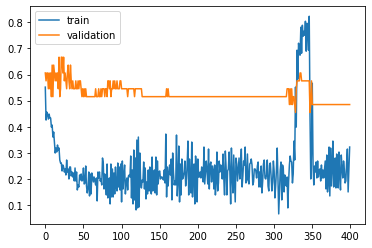

In [7]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [8]:
# Anagha's Implementation

model = models.Sequential([
    layers.Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(5, activation='softmax'),
    layers.Dense(2)  # Use 2 output units for binary classification
])

tf.keras.optimizers.SGD(
    learning_rate=0.001,
)

model.compile(optimizer='SGD',
              loss=['mse'],
              metrics=['accuracy']
             )


# Step 3: Train and evaluate model

history2 = model.fit(X_train, Y_train, epochs=300, batch_size=20, 
                    validation_data=(X_val, Y_val))

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/300
14/14 [==============================] - 1s 28ms/step - loss: 0.2551 - accuracy: 0.4291 - val_loss: 0.2657 - val_accuracy: 0.4848
Epoch 2/300
14/14 [==============================] - 0s 12ms/step - loss: 0.2492 - accuracy: 0.4291 - val_loss: 0.2561 - val_accuracy: 0.4848
Epoch 3/300
14/14 [==============================] - 0s 12ms/step - loss: 0.2457 - accuracy: 0.4291 - val_loss: 0.2599 - val_accuracy: 0.4848
Epoch 4/300
14/14 [==============================] - 0s 14ms/step - loss: 0.2446 - accuracy: 0.4291 - val_loss: 0.2541 - val_accuracy: 0.4848
Epoch 5/300
14/14 [==============================] - 0s 15ms/step - loss: 0.2426 - accuracy: 0.4291 - val_loss: 0.2537 - val_accuracy: 0.4848
Epoch 6/300
14/14 [==============================] - 0s 15ms/step - loss: 0.2425 - accuracy: 0.4291 - val_loss: 0.2537 - val_accuracy: 0.4848
Epoch 7/300
14/14 [==============================] - 0s 12ms/step - loss: 0.2420 - accuracy: 0.4559 - val_loss: 0.2528 - val_accuracy: 0.5152
Epoch 

14/14 [==============================] - 0s 14ms/step - loss: 0.1116 - accuracy: 0.4943 - val_loss: 0.2736 - val_accuracy: 0.4545
Epoch 116/300
14/14 [==============================] - 0s 13ms/step - loss: 0.1048 - accuracy: 0.5096 - val_loss: 0.2726 - val_accuracy: 0.4848
Epoch 117/300
14/14 [==============================] - 0s 12ms/step - loss: 0.0993 - accuracy: 0.5134 - val_loss: 0.2747 - val_accuracy: 0.4545
Epoch 118/300
14/14 [==============================] - 0s 13ms/step - loss: 0.1071 - accuracy: 0.5287 - val_loss: 0.3328 - val_accuracy: 0.4848
Epoch 119/300
14/14 [==============================] - 0s 13ms/step - loss: 0.1140 - accuracy: 0.5249 - val_loss: 0.4246 - val_accuracy: 0.4848
Epoch 120/300
14/14 [==============================] - 0s 14ms/step - loss: 0.1373 - accuracy: 0.4943 - val_loss: 0.4437 - val_accuracy: 0.5455
Epoch 121/300
14/14 [==============================] - 0s 13ms/step - loss: 0.1160 - accuracy: 0.5211 - val_loss: 0.2932 - val_accuracy: 0.4848
Epoch 

Epoch 172/300
14/14 [==============================] - 0s 10ms/step - loss: 0.0454 - accuracy: 0.5402 - val_loss: 0.3058 - val_accuracy: 0.5455
Epoch 173/300
14/14 [==============================] - 0s 12ms/step - loss: 0.0386 - accuracy: 0.5402 - val_loss: 0.3047 - val_accuracy: 0.5455
Epoch 174/300
14/14 [==============================] - 0s 11ms/step - loss: 0.0316 - accuracy: 0.5517 - val_loss: 0.3128 - val_accuracy: 0.5455
Epoch 175/300
14/14 [==============================] - 0s 11ms/step - loss: 0.0296 - accuracy: 0.5479 - val_loss: 0.3222 - val_accuracy: 0.5455
Epoch 176/300
14/14 [==============================] - 0s 13ms/step - loss: 0.0320 - accuracy: 0.5441 - val_loss: 0.4197 - val_accuracy: 0.5455
Epoch 177/300
14/14 [==============================] - 0s 13ms/step - loss: 0.0460 - accuracy: 0.5441 - val_loss: 0.3107 - val_accuracy: 0.5455
Epoch 178/300
14/14 [==============================] - 0s 12ms/step - loss: 0.0274 - accuracy: 0.5479 - val_loss: 0.3630 - val_accuracy:

Epoch 229/300
14/14 [==============================] - 0s 10ms/step - loss: 0.0103 - accuracy: 0.5785 - val_loss: 0.3230 - val_accuracy: 0.5758
Epoch 230/300
14/14 [==============================] - 0s 10ms/step - loss: 0.0109 - accuracy: 0.5862 - val_loss: 0.3222 - val_accuracy: 0.5758
Epoch 231/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0109 - accuracy: 0.5862 - val_loss: 0.3215 - val_accuracy: 0.5758
Epoch 232/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0098 - accuracy: 0.5824 - val_loss: 0.3643 - val_accuracy: 0.5152
Epoch 233/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0117 - accuracy: 0.5824 - val_loss: 0.3923 - val_accuracy: 0.5758
Epoch 234/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0170 - accuracy: 0.5900 - val_loss: 0.3302 - val_accuracy: 0.5758
Epoch 235/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0108 - accuracy: 0.5900 - val_loss: 0.3318 - val_accuracy: 0.57

14/14 [==============================] - 0s 10ms/step - loss: 0.0052 - accuracy: 0.5747 - val_loss: 0.3296 - val_accuracy: 0.5758
Epoch 287/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0053 - accuracy: 0.5824 - val_loss: 0.3257 - val_accuracy: 0.5758
Epoch 288/300
14/14 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.5900 - val_loss: 0.3233 - val_accuracy: 0.5758
Epoch 289/300
14/14 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.5900 - val_loss: 0.3243 - val_accuracy: 0.5455
Epoch 290/300
14/14 [==============================] - 0s 10ms/step - loss: 0.0049 - accuracy: 0.5900 - val_loss: 0.3236 - val_accuracy: 0.5758
Epoch 291/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0050 - accuracy: 0.5977 - val_loss: 0.3247 - val_accuracy: 0.5758
Epoch 292/300
14/14 [==============================] - 0s 10ms/step - loss: 0.0052 - accuracy: 0.5939 - val_loss: 0.3249 - val_accuracy: 0.5758
Epoch 29

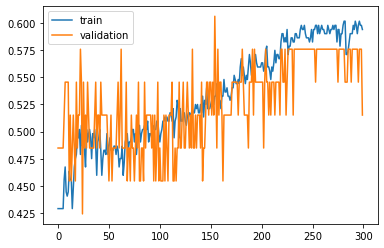

In [9]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [10]:
# Anagha's Implementation

model = models.Sequential([
    layers.Conv2D(5, (3,3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='sigmoid')  # Use 2 output units for binary classification
])

tf.keras.optimizers.Adam(
    learning_rate=0.001,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
             )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Step 3: Train and evaluate model

history2 = model.fit(X_train, Y_train, epochs=200, batch_size=60, 
                    validation_data=(X_val, Y_val), callbacks=[callback])

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/200
5/5 [==============================] - 1s 67ms/step - loss: 0.7620 - accuracy: 0.5249 - val_loss: 0.7589 - val_accuracy: 0.4848
Epoch 2/200
5/5 [==============================] - 0s 27ms/step - loss: 0.7307 - accuracy: 0.5670 - val_loss: 0.7562 - val_accuracy: 0.4545
Epoch 3/200
5/5 [==============================] - 0s 25ms/step - loss: 0.7255 - accuracy: 0.5479 - val_loss: 0.7504 - val_accuracy: 0.4545
Epoch 4/200
5/5 [==============================] - 0s 32ms/step - loss: 0.7078 - accuracy: 0.5556 - val_loss: 0.7489 - val_accuracy: 0.4848
Epoch 5/200
5/5 [==============================] - 0s 31ms/step - loss: 0.6999 - accuracy: 0.5747 - val_loss: 0.7361 - val_accuracy: 0.5455
Epoch 6/200
5/5 [==============================] - 0s 30ms/step - loss: 0.6921 - accuracy: 0.6207 - val_loss: 0.7268 - val_accuracy: 0.5758
Epoch 7/200
5/5 [==============================] - 0s 32ms/step - loss: 0.6882 - accuracy: 0.6284 - val_loss: 0.7252 - val_accuracy: 0.5758
Epoch 8/200
5/5 [===

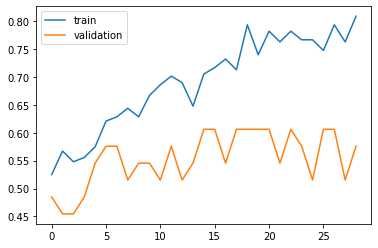

In [11]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [12]:
# Anagha's Implementation

model = models.Sequential([
    layers.Conv2D(5, (3,3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='relu')  # Use 2 output units for binary classification
])

tf.keras.optimizers.Adam(
    learning_rate=0.1,
)

model.compile(optimizer='Adam',
              loss=tf.keras.losses.Poisson(reduction="auto", name="poisson"),
              metrics=['accuracy'],
             )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Step 3: Train and evaluate model

history2 = model.fit(X_train, Y_train, epochs=400, batch_size=10, 
                    validation_data=(X_val, Y_val), callbacks=[callback])

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/400
27/27 [==============================] - 1s 18ms/step - loss: 4.1200 - accuracy: 0.5709 - val_loss: 5.0842 - val_accuracy: 0.5152
Epoch 2/400
27/27 [==============================] - 0s 9ms/step - loss: 4.0831 - accuracy: 0.5709 - val_loss: 4.5423 - val_accuracy: 0.5152
Epoch 3/400
27/27 [==============================] - 0s 9ms/step - loss: 4.0241 - accuracy: 0.5709 - val_loss: 4.6308 - val_accuracy: 0.5152
Epoch 4/400
27/27 [==============================] - 0s 10ms/step - loss: 4.0083 - accuracy: 0.5709 - val_loss: 4.6325 - val_accuracy: 0.5152
Epoch 5/400
27/27 [==============================] - 0s 11ms/step - loss: 3.9327 - accuracy: 0.5709 - val_loss: 4.6258 - val_accuracy: 0.5152
Epoch 6/400
27/27 [==============================] - 0s 10ms/step - loss: 3.9306 - accuracy: 0.5709 - val_loss: 4.6231 - val_accuracy: 0.5152
Epoch 7/400
27/27 [==============================] - 0s 9ms/step - loss: 3.9017 - accuracy: 0.5709 - val_loss: 4.4525 - val_accuracy: 0.5152
Epoch 8/4

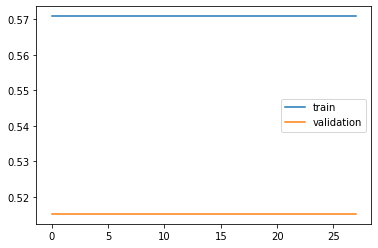

In [13]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

## Comapring the results of all the tests in tabular format by Leelakrishna

In [18]:
table = pd.DataFrame([[0.5757, 1.7832 , 0.5455, 2.7708, 'Null', 32, 0.1, 500, 'SGD', 'relu', 'SparseCategoricalCrossentropy',8],
        [0.3030, 0.1925, 0.5152, 0.3631, 'Null', 50, 0.01, 400, 'Adam', 'relu', 'mse', 5],
        [0.4848, 0.2723, 0.5455, 0.3736, 'Null', 20, 0.001, 300, 'SGD', 'relu|softmax', 'mse', 4],
        [0.6573, 0.6705, 0.4848, 0.7693, 0.2, 60, 0.001, 200, 'Adam', 'relu|sigmoid', 'SparseCategoricalCrossentropy', 5],
        [0.5152, 0.6889, 0.6667, 0.89, 0.2, 10, 0.1, 400, 'Adam', 'relu', 'poisson', 5],
        [0.0690, 6.2492, 0.0606, 6.2893, 'Null', '', 0.001, 10, 'Adam', 'relu', 'CrossEntropyLoss', 1]],
                    columns=['Train_Accuracy', 'Train_Loss', 'Val_Accuracy', 'Val_Loss', 'Dropout','Batch size', 'LR', 'Epochs', 
                             'Optimizer', 'Activation', 'Loss', 'Layers'])

In [19]:
print("Test Results")
table

Test Results


,Train_Accuracy,Train_Loss,Val_Accuracy,Val_Loss,Dropout,Batch size,LR,Epochs,Optimizer,Activation,Loss,Layers
0,0.5757,1.7832,0.5455,2.7708,Null,32,0.100,500,SGD,relu,SparseCategoricalCrossentropy,8
1,0.3030,0.1925,0.5152,0.3631,Null,50,0.010,400,Adam,relu,mse,5
2,0.4848,0.2723,0.5455,0.3736,Null,20,0.001,300,SGD,relu|softmax,mse,4
3,0.6573,0.6705,0.4848,0.7693,0.2,60,0.001,200,Adam,relu|sigmoid,SparseCategoricalCrossentropy,5
4,0.5152,0.6889,0.6667,0.8900,0.2,10,0.100,400,Adam,relu,poisson,5
5,0.0690,6.2492,0.0606,6.2893,Null,,0.001,10,Adam,relu,CrossEntropyLoss,1


In the above table, the last observation is obtained from custom CNN. Also various tests were carried out but while doing it we forgot to note the results and only a few were listed here. All of them were facing overfitting. 

# How to change the code to work over 1-Dimensional data? 
We would only need 1 for loop in out custom layer and that just goes across one row. The pooling layer would only be 1 
dimension.

# How to change the code to work over 3-Dimensional data?
We would need another nested for loop in our custom layer to account for the extra dimension. The pooling layer would be 3 dimensions in the combined network.

# References

https://towardsdatascience.com/building-a-convolutional-neural-network-from-scratch-using-numpy-a22808a00a40

https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

https://www.tensorflow.org/tutorials/images/cnn

https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/